In [1]:
import sys
sys.path.append('C:\\Program Files (x86)\\PIPC\\AF\\PublicAssemblies\\4.0\\')
import clr
clr.AddReference('OSIsoft.AFSDK')
clr.AddReference('System.Net')
import numpy as np
from OSIsoft.AF.PI import *
from OSIsoft.AF.Search import *
from OSIsoft.AF.Asset import *
from OSIsoft.AF.Data import *
from OSIsoft.AF.Time import *
from System.Net import NetworkCredential
from System import TimeSpan
import pandas as pd
import pyodbc
import csv
from tqdm import tqdm
import datetime
from matplotlib import pyplot as plt

In [2]:
def connect_to_Server(serverName='149.179.68.101', verbose=False):
	'''Connects to the PI Server, if verbose prints a snapshot to confirm

	Arguments:
    ----------------------------------
    serverName (str) -> Use the default that's the L48 Server
	verbose (bool)-> If true prints a snapshot, run to check connections

    Returns:
    ----------------------------------
    None -> Just instantiates the connection and allows you to use PI server

	'''
	print("Now Connecting To PI Severs")
	piServers = PIServers()
	global piServer
	piServer = piServers[serverName]

	cred = NetworkCredential('piuser','')

	piServer.Connect(cred)
	print("Connected Successfully")
	if verbose:
		tag = PIPoint.FindPIPoint(piServer, "sinusoid")
		lastData = tag.Snapshot()

		print('Snapshot Value:\nTimestamp: {0} Value: {1}\n\n'.format(lastData.Timestamp, lastData.Value))

		startTime = AFTime.Now
		count = 10
		forward = False;
		boundary = AFBoundaryType.Inside
		filter = ""
		includeFiltered = True

		archiveData = tag.RecordedValuesByCount(startTime, count, forward, boundary, filter, includeFiltered)

		print('Last 10 Archive Values:\n')
		for item in archiveData :
			print('Timestamp: {0} Value: {1}'.format(item.Timestamp, item.Value))

def get_tag_values(tagname,timestart,timeend):
	'''Get point values for a tagname from timerange. These timeranges are
	specific to Obisoft, be careful trying different strings, you may get
	bizarre errors, that are caused from .NET passing stuff through. Not all
	wells have all tages BTW.

	List of what I know:
		't'  -> Beginning of today, end of last night, about midnight
		's'  -> seconds
		'm'  -> minutes
		'h'  -> hour
		'd'  -> day
		'y'  -> year
		'8m' -> 8 minutes
		'-8m'-> 8 minutes ago
		'+8m'-> 8 minutes from now
		'04/01/2018' -> 12:00:00 AM on April 1st, 2018

	Arguments:
	----------------------------------
	tagname (str) -> A well name and the tag you are looking for
	timestart (str) -> The start time, don't pass datetime objects in here
	timeend (str) -> The end time, don't pass datetime objects in here

	Returns:
	----------------------------------
	data (list of lists) -> A list of lists, where each element contains a list
		consisting of a timestamp (str) and values(str).

	Ex.
	----------------------------------
	>>> data = get_tag_values('WAM-CH222D5.TUB_PSI','-8d','t')

	>>> data

	<<< [['4/23/2018 12:05:01 AM', '398.9319'],
	 	['4/23/2018 12:20:05 AM', '404.6538'],
		['4/23/2018 12:22:05 AM', '384.1693']...]
	'''
	tag = PIPoint.FindPIPoint(piServer, tagname)
	timeRange = AFTimeRange(timestart, timeend)
	boundary = AFBoundaryType.Inside
	data = tag.RecordedValues(timeRange,boundary,'',False,0)
	dataList = []
	for i, sample in enumerate(data):
	    dataList.append([str(sample.Timestamp), str(sample.Value)])
	return dataList


def find_tags(mask):
	'''Prints the tag names for whatevers in mask. An example of how to get
	this to work is as follows:

	my_list = find_tags('WAM-CH222A2.*')

	>>> my_list

	<<<['WAM-CH222A2.AIR_TMP',
 	 	'WAM-CH222A2.API_NUM',
 		'WAM-CH222A2.BATT_12VDC',
 		'WAM-CH222A2.BATT_5VDC',
 		'WAM-CH222A2.CAS_PSI',
 		'WAM-CH222A2.CAS_PSI_24H_AVG',...]

	Arguments:
    ----------------------------------
    mask -> A pi well tag, '*' is the wildcard here.

    Returns:
    ----------------------------------
    my_list (list) -> A list of possible tagnames

	'''
	points = PIPoint.FindPIPoints(piServer, mask, None, None)
	points = list(points) #casting it to a Python list
	return [i.get_Name() for i in points]

def get_tag_interpolate(tagname, timestart, timeend, seconds=0, minutes=0, hours=0):
    '''Get interpolated data. This query fetches interpolated data based on the
    tagname in the timestart and timeend range. The time interval is passed
    through the second, minute and hours arguments

    List of what I know:
        't'  -> Beginning of today, end of last night, about midnight
        's'  -> seconds
        'm'  -> minutes
        'h'  -> hour
        'd'  -> day
        'y'  -> year
        '8m' -> 8 minutes
        '-8m'-> 8 minutes ago
        '+8m'-> 8 minutes from now
        '04/01/2018' -> 12:00:00 AM on April 1st, 2018


    Arguments:
    ----------------------------------
    tagname (str) -> A well name and the tag you are looking for
    timestart (str) -> The start time, don't pass datetime objects in here
    timeend (str) -> The end time, don't pass datetime objects in here
    seconds (int) -> Seconds between intervals (careful, this will generate a
                    lot of data)
    minutes (int) -> Minutes between intervals
    hours (int) -> hours between intervals
    Returns:
    ----------------------------------
    data (list of lists) -> A list of lists, where each element contains a list
        consisting of a timestamp (str) and values(str).

    Ex.
    ----------------------------------
    data = get_tag_interpolate('WAM-CH222D5.TUB_PSI','-8d','t', seconds=0,
                 minutes=15, hours=0)
    data

    <<< [['4/23/2018 12:00:00 AM', '394.8289'],
            ['4/23/2018 12:15:00 AM', '402.7233'],
            ['4/23/2018 12:30:00 AM', '212.2917']...]
    '''
    tag = PIPoint.FindPIPoint(piServer, tagname)
    timeRange = AFTimeRange(timestart, timeend)
    full_timespan = TimeSpan(hours, minutes, seconds)
    timeSpan = AFTimeSpan(full_timespan)
    data = tag.InterpolatedValues(timeRange, timeSpan, '', False)
    dataList = []
    for i, sample in enumerate(data):
        dataList.append([str(sample.Timestamp), str(sample.Value)])
    return dataList

In [3]:
connect_to_Server()

Now Connecting To PI Severs
Connected Successfully


In [4]:
sales_line_tags = find_tags('WAM*Sales*PSI')

In [11]:
def get_gas_vy(x):
    y = x.split('.')[0]
    y = y + '.GAS_VY'
    return y

In [12]:
sales_line_tags

['WAM-3MILE1-1.SALES_LINE_PSI',
 'WAM-3MILE1-2.SALES_LINE_PSI',
 'WAM-3MILE11-140D.SALES_LINE_PSI',
 'WAM-3MILE11-20D.SALES_LINE_PSI',
 'WAM-3MILE11-80D.SALES_LINE_PSI',
 'WAM-3MILE11P.SALES_LINE_PSI',
 'WAM-3MILE15-1.SALES_LINE_PSI',
 'WAM-3MILE15-100.SALES_LINE_PSI',
 'WAM-3MILE15-2.SALES_LINE_PSI',
 'WAM-3MILE15-3.SALES_LINE_PSI',
 'WAM-3MILE23-1.SALES_LINE_PSI',
 'WAM-3MILE23-100D.SALES_LINE_PSI',
 'WAM-3MILE23-2.SALES_LINE_PSI',
 'WAM-3MILE23-70D.SALES_LINE_PSI',
 'WAM-5MILE1.SALES_LINE_PSI',
 'WAM-5MILE11-1.SALES_LINE_PSI',
 'WAM-5MILE11.SALES_LINE_PSI',
 'WAM-5MILE13-1.SALES_LINE_PSI',
 'WAM-5MILE15-1.SALES_LINE_PSI',
 'WAM-5MILE17-1.SALES_LINE_PSI',
 'WAM-5MILE19-1.SALES_LINE_PSI',
 'WAM-5MILE19-2.SALES_LINE_PSI',
 'WAM-5MILE19-3.SALES_LINE_PSI',
 'WAM-5MILE21-1.SALES_LINE_PSI',
 'WAM-5MILE25-1.SALES_LINE_PSI',
 'WAM-5MILE29-1.SALES_LINE_PSI',
 'WAM-5MILE31-1.SALES_LINE_PSI',
 'WAM-5MILE31-2.SALES_LINE_PSI',
 'WAM-5MILE31-3.SALES_LINE_PSI',
 'WAM-5MILE31-4.SALES_LINE_PSI',
 'WA

In [13]:
gas_line_tags = [get_gas_vy(x) for x in sales_line_tags]

In [16]:
len(gas_line_tags) == len(sales_line_tags)

True

In [6]:
get_tag_interpolate(sales_line_tags[0], '-365d', '*',0,0,24)


[['8/7/2017 4:13:30 PM', 'Pt Created'],
 ['8/8/2017 4:13:30 PM', 'Pt Created'],
 ['8/9/2017 4:13:30 PM', 'Pt Created'],
 ['8/10/2017 4:13:30 PM', 'Pt Created'],
 ['8/11/2017 4:13:30 PM', 'Pt Created'],
 ['8/12/2017 4:13:30 PM', 'Pt Created'],
 ['8/13/2017 4:13:30 PM', 'Pt Created'],
 ['8/14/2017 4:13:30 PM', 'Pt Created'],
 ['8/15/2017 4:13:30 PM', 'Pt Created'],
 ['8/16/2017 4:13:30 PM', 'Pt Created'],
 ['8/17/2017 4:13:30 PM', 'Pt Created'],
 ['8/18/2017 4:13:30 PM', 'Pt Created'],
 ['8/19/2017 4:13:30 PM', 'Pt Created'],
 ['8/20/2017 4:13:30 PM', 'Pt Created'],
 ['8/21/2017 4:13:30 PM', 'Pt Created'],
 ['8/22/2017 4:13:30 PM', 'Pt Created'],
 ['8/23/2017 4:13:30 PM', 'Pt Created'],
 ['8/24/2017 4:13:30 PM', 'Pt Created'],
 ['8/25/2017 4:13:30 PM', 'Pt Created'],
 ['8/26/2017 4:13:30 PM', 'Pt Created'],
 ['8/27/2017 4:13:30 PM', 'Pt Created'],
 ['8/28/2017 4:13:30 PM', 'Pt Created'],
 ['8/29/2017 4:13:30 PM', 'Pt Created'],
 ['8/30/2017 4:13:30 PM', 'Pt Created'],
 ['8/31/2017 4:13:3

In [7]:
scc

NameError: name 'scc' is not defined

In [17]:
def getmoredays(tags, days=365):
    results = []
    df = pd.DataFrame(columns = ['Tag', 'DateTime', 'Sales_Line_Value', 'Gas_VY'])
    tagslist=[]
    values=[]
    datetimes=[]
    for tag in tqdm(tags):
        gas_tag = get_gas_vy(tag)
        try:
            tagslist=[]
            values=[]
            datetimes=[]
            gas_vy = []
            temp_df = pd.DataFrame(columns = ['Tag', 'DateTime', 'Sales_Line_Value', 'Gas_VY'])
            results = get_tag_interpolate(tag, '-{}d'.format(days), 't',0,0,24)
            gas_results = get_tag_interpolate(gas_tag, '-{}d'.format(days), 't',0,0,24)                            
            for i in range(len(results)):
                tagslist.append(tag)
                values.append(results[i][1])
                gas_vy.append(gas_results[i][1])
                datetimes.append(results[i][0])
            temp_df['Tag']=tagslist
            temp_df['DateTime']=datetimes
            temp_df['Gas_VY']=gas_vy
            temp_df['Gas_VY'] = pd.to_numeric(temp_df['Gas_VY'], errors = 'coerce')
            temp_df['Sales_Line_Value']=values
            temp_df['Sales_Line_Value'] = pd.to_numeric(temp_df['Sales_Line_Value'], errors = 'coerce')
            temp_df['DateTime'] = pd.to_datetime(temp_df['DateTime'], errors='coerce')
            temp_df['JustDate'] = temp_df['DateTime'].dt.date
            df = pd.concat([temp_df, df], axis = 0)
        except PIException:
            continue
    return df

In [18]:
len(sales_line_tags)

2021

In [19]:
df = getmoredays(sales_line_tags[:100])

100%|████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


In [20]:
df.head()

,DateTime,Gas_VY,JustDate,Sales_Line_Value,Tag
0,2017-08-09,148.14050,2017-08-09,70.09236,WAM-CB11_60-100D.SALES_LINE_PSI
1,2017-08-10,164.61190,2017-08-10,43.73603,WAM-CB11_60-100D.SALES_LINE_PSI
2,2017-08-11,37.21646,2017-08-11,73.70723,WAM-CB11_60-100D.SALES_LINE_PSI
3,2017-08-12,155.78950,2017-08-12,64.93257,WAM-CB11_60-100D.SALES_LINE_PSI
4,2017-08-13,174.19670,2017-08-13,84.01060,WAM-CB11_60-100D.SALES_LINE_PSI


In [21]:
temp1 = df[df['Tag']==df['Tag'].unique()[4]]

In [22]:
temp1['Rolling']=temp1['Sales_Line_Value'].rolling(7).mean()
temp1['Rolling_gas']=temp1['Gas_VY'].rolling(7).mean()
temp1['Rolling_std']=temp1['Sales_Line_Value'].rolling(7).std()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [23]:
X = temp1['Rolling'].values
X_std = temp1['Rolling_std'].values
X_gas = temp1['Rolling_gas'].values

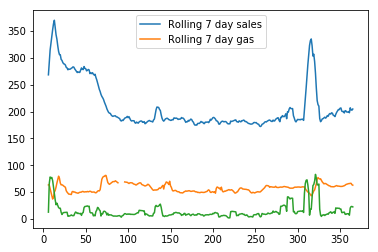

In [27]:
plt.plot(temp1['Rolling'].values, label ='Rolling 7 day sales')
plt.plot(temp1['Rolling_gas'].values, label = 'Rolling 7 day gas')
plt.plot(X_std)
plt.legend()

In [30]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

In [31]:
X_std=X_std[~np.isnan(X_std)]

In [32]:
clf = svm.OneClassSVM(nu=0.4, kernel="rbf", gamma=0.00001)
clf.fit(X_std.reshape((-1,1)))
y_pred = clf.predict(X_std.reshape((-1,1)))

In [33]:
y_mask = (y_pred>0) * 1

In [34]:
X[:5]

array([nan, nan, nan, nan, nan])

In [35]:
y_pred = np.ones((X.shape))

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()

In [68]:
temp1.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

(366,)


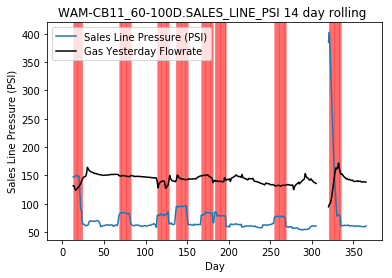

(366,)


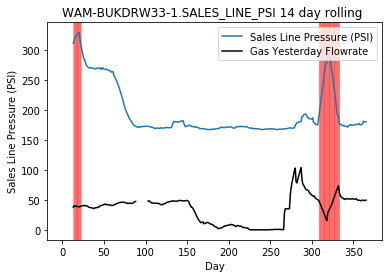

(366,)


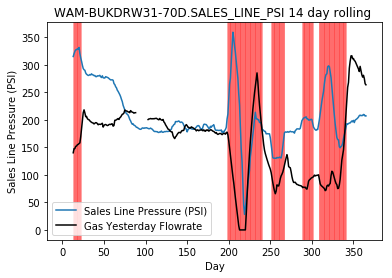

(366,)


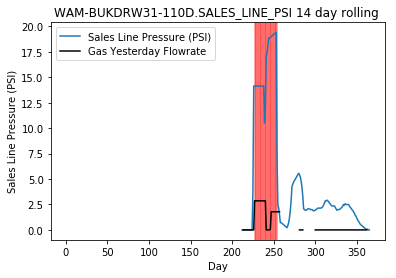

(366,)


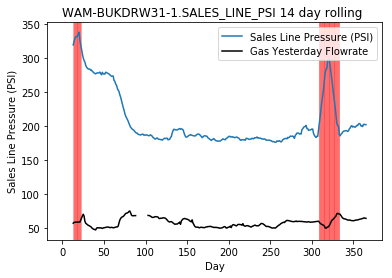

In [37]:
for tag in df['Tag'].unique()[:5]:
    temp1 = df[df['Tag']==tag]
    temp1['Rolling']=temp1['Sales_Line_Value'].rolling(14, center = False).mean()
    temp1['Rolling_gas']=temp1['Gas_VY'].rolling(14, center = False).mean()
    temp1['Rolling_std']=temp1['Sales_Line_Value'].rolling(14, center = False).std()
    X_1 = temp1['Rolling'].values
    X = temp1['Rolling_std'].values
    X_gas=temp1['Rolling_gas'].values
#     X_1=X_1[~np.isnan(X_1)]
#     X=X[~np.isnan(X)]
    y_pred = np.ones((X.shape))
    y_pred[X>35] = 0
    print (y_pred.shape)
#     try:
#         clf.fit(X.reshape((-1,1)))
#     except:
#         continue
#     y_pred = clf.predict(X.reshape((-1,1)))
    fig, ax = plt.subplots()
    ax.plot(X_1, label= 'Sales Line Pressure (PSI)' )
    ax.plot(X_gas, label = 'Gas Yesterday Flowrate', color = 'black')
    for i in range(0, len(X)):
        ax.axvspan(i, i+1, color='red', alpha=((y_pred[i]-1)*-1)/4)
    plt.ylabel('Sales Line Pressure (PSI)')
    plt.xlabel('Day')
    plt.legend()
    plt.title(tag + ' 14 day rolling ')
    plt.show()
    

In [38]:
X


array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 62.14340028, 60.7471792 ,
       58.03844879, 55.9638816 , 55.9638816 , 54.80835743, 51.9274642 ,
       47.9580861 , 39.92107598, 31.26490853, 31.12858832, 25.79206795,
       20.68337975, 18.89938658, 20.0899078 , 14.62197654, 11.24844312,
       10.36053374, 10.46606237, 10.46606237, 10.36159434,  9.42873793,
        9.54917867,  6.0854718 ,  7.69329664,  9.62254678,  9.52498161,
        9.59853469,  9.55838048,  9.60311305,  9.47872111,  9.89727457,
       10.12015723, 11.27576415, 11.01547363, 17.00226229, 17.65854399,
       17.63612676, 17.63612676, 17.34206599, 17.4658222 , 18.11077028,
       18.0329369 , 18.08405284, 18.3542671 , 17.86887527, 17.4286615 ,
       17.30146408, 17.20209545, 13.15941981, 15.18331212, 19.01011876,
       20.24031447, 19.00780638, 19.6016651 , 20.24262177, 21.72

In [ ]:
plt.plot(X, alpha =y_pred )

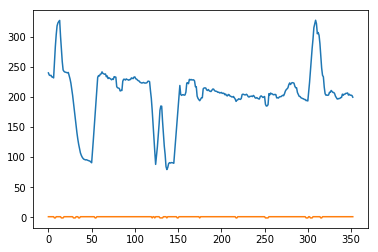

In [89]:
plt.plot(X)
y_pred

In [67]:
df2['shift'] = df2['Value'].shift(1)

In [69]:
df2

,DateTime,JustDate,Tag,Value,shift
0,2018-07-30 15:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,NaN
1,2018-07-30 16:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
2,2018-07-30 17:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
3,2018-07-30 18:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
4,2018-07-30 19:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
5,2018-07-30 20:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
6,2018-07-30 21:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
7,2018-07-30 22:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
8,2018-07-30 23:06:07,2018-07-30,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF
9,2018-07-31 00:06:07,2018-07-31,WAM-3MILE11-20D.Z:SCC_ST,OFF,OFF


In [39]:
df['Value'].unique()

array(['ON', 'No Data', 'OFF'], dtype=object)

In [40]:
df['Well'] = df['Tag'].map(lambda x: x.split(".")[0])
df['Tag_2'] = df['Tag'].map(lambda x: x.split(".")[1])

In [41]:
df['Value'].unique()

array(['ON', 'No Data', 'OFF'], dtype=object)

In [42]:
df2 = df.groupby(['Well', 'DateTime', 'Tag_2'])['Value'].sum().unstack('Tag_2')

In [44]:
df.to_csv('scc_sample_data.csv')

In [65]:
df2.to_csv('choke_flow_2.csv')

In [60]:
df.to_csv('choke_flow_pi_data.csv')

In [62]:
df.pivot(index=['DateTime', values='Value', columns='Tag_2')

NotImplementedError: > 1 ndim Categorical are not supported at this time

In [10]:
def getyesterday(tags):
    results = []
    df = pd.DataFrame(columns = ['Tag', 'DateTime', 'Value'])
    tagslist=[]
    values=[]
    datetimes=[]
    for tag in tqdm(tags):
        results = get_tag_values(tag, '-1d', '*')
        if len(results) > 0:
            results=results[-1]
            tagslist.append(tag)
            values.append(results[1])
            datetimes.append(results[0])
    df['Tag']=tagslist
    df['DateTime']=datetimes
    df['Value']=values
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df['JustDate'] = df['DateTime'].dt.date

#     sql_push(df, 'CCS_data')
    return df

def sql_push(df, table, if_exists='append'):
    '''
    write the given pandas df to the sqldw table name provided, we're not appending to the table
    but replacing the table with the given pandas dataframe.
    '''
    params = urllib.parse.quote_plus('Driver={SQL Server Native Client 11.0};\
                                         Server=SQLDW-L48.BP.Com;\
                                         Database=TeamOptimizationEngineering;\
                                         trusted_connection=yes'
    )
    engine = sqlalchemy.create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

    print('[+] Writing Data')
    df.to_sql(table, engine, schema='PI', if_exists=if_exists, index=False)
    print('[++] Data Written Successfully and Connection Closed')

In [11]:
df = getyesterday(tags)

100%|████████████████████████████████████████| 886/886 [01:25<00:00, 10.33it/s]


In [17]:
df[df['Value']>1]

,Tag,DateTime,Value,JustDate,Produced_date
0,WAM-BB19-80H.CHOK_FLW_PV,2018-07-24 13:00:42,100.000000,2018-07-24,2018-07-23
24,WAM-CB20_20D-110D.CHOK_FLW_PV,2018-07-24 15:58:18,1.194955,2018-07-24,2018-07-23
26,WAM-CB20_20D-150D.CHOK_FLW_PV,2018-07-24 15:50:29,1.167191,2018-07-24,2018-07-23
42,WAM-CB33_40D-130D.CHOK_FLW_PV,2018-07-24 15:52:48,1.035708,2018-07-24,2018-07-23
43,WAM-CB33_40D-140D.CHOK_FLW_PV,2018-07-24 15:53:08,1.190568,2018-07-24,2018-07-23
81,WAM-CGR20_70D-75D.CHOK_FLW_PV,2018-07-24 15:55:05,1.192753,2018-07-24,2018-07-23
87,WAM-CGR25_10D-40D.CHOK_FLW_PV,2018-07-24 15:59:28,1.679975,2018-07-24,2018-07-23
107,WAM-CGR36_20D-80D.CHOK_FLW_PV,2018-07-24 16:00:50,1.264850,2018-07-24,2018-07-23
109,WAM-CGR3S15D-40D.CHOK_FLW_PV,2018-07-24 15:56:27,1.003074,2018-07-24,2018-07-23
114,WAM-CGR3_10D-130D.CHOK_FLW_PV,2018-07-24 16:02:47,1.366668,2018-07-24,2018-07-23


In [17]:
df = getmoredays(tags, 30)


 87%|██████████████████████████████████▋     | 335/387 [00:36<00:05,  9.30it/s]


100%|████████████████████████████████████████| 387/387 [00:41<00:00,  9.28it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128741 entries, 0 to 128740
Data columns (total 5 columns):
Tag              128741 non-null object
DateTime         128741 non-null datetime64[ns]
Value            124979 non-null float64
JustDate         128741 non-null object
Produced_date    128741 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 4.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11018 entries, 0 to 128740
Data columns (total 5 columns):
Tag              11018 non-null object
DateTime         11018 non-null datetime64[ns]
Value            10701 non-null float64
JustDate         11018 non-null object
Produced_date    11018 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 516.5+ KB
None


In [18]:
df_30_day = df.copy()

In [ ]:
sql_push(df, 'CCS_data', 'replace' )

[+] Writing Data


In [78]:
df_30_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128068 entries, 0 to 128067
Data columns (total 4 columns):
Tag         128068 non-null object
DateTime    128068 non-null datetime64[ns]
Value       124305 non-null float64
JustDate    128068 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.9+ MB


In [79]:
df_30_day.drop_duplicates(subset=['Tag','JustDate']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10825 entries, 0 to 128067
Data columns (total 4 columns):
Tag         10825 non-null object
DateTime    10825 non-null datetime64[ns]
Value       10513 non-null float64
JustDate    10825 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 422.9+ KB


In [83]:
df_30_day['Produced_date']=df_30_day['JustDate'] - datetime.timedelta(days=1)

In [84]:
df_30_day

,Tag,DateTime,Value,JustDate,Produced_date
0,WAM-8MILE7-1.CCS_VY,2018-06-25 03:01:36,1.237065,2018-06-25,2018-06-24
1,WAM-8MILE7-1.CCS_VY,2018-06-26 03:01:20,1.087152,2018-06-26,2018-06-25
2,WAM-8MILE7-1.CCS_VY,2018-06-27 03:01:33,1.602429,2018-06-27,2018-06-26
3,WAM-8MILE7-1.CCS_VY,2018-06-28 03:01:44,2.168162,2018-06-28,2018-06-27
4,WAM-8MILE7-1.CCS_VY,2018-06-29 03:01:15,2.248013,2018-06-29,2018-06-28
5,WAM-8MILE7-1.CCS_VY,2018-06-30 03:01:21,2.080111,2018-06-30,2018-06-29
6,WAM-8MILE7-1.CCS_VY,2018-07-01 03:02:06,2.356164,2018-07-01,2018-06-30
7,WAM-8MILE7-1.CCS_VY,2018-07-02 03:01:39,2.206278,2018-07-02,2018-07-01
8,WAM-8MILE7-1.CCS_VY,2018-07-03 03:01:23,2.068567,2018-07-03,2018-07-02
9,WAM-8MILE7-1.CCS_VY,2018-07-04 03:01:13,2.003166,2018-07-04,2018-07-03


In [22]:
import urllib
import sqlalchemy